**WELCOME TO THE PYTHON ENVIRONMENT**

In [1]:
# Installing packages

!pip install pyhrv
!pip install biosppy
!pip install peakutils

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.5/231.5 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.0/158.0 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.7/225.7 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.2/750.2 kB 31.0 MB/s eta 0:00:00
  Created wheel for spectrum: filename=spectrum-0.9.0-cp311-cp311-linux_x86_64.whl size=236749 sha256=caab7c93eae68faaf5844fad5bf0e7b8507ac36f891f0981d7992415484d96a1
  Stored in directory: /root/.cache/pip/wheels/c0/9c/de/eb558fbd03ea1540d3c908f23681f57f9d9e8c2a5cd08d6f42
Successfully built spectrum


In [2]:
# Importing packages

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import biosppy
import pyhrv
import pyhrv.time_domain as td
import pyhrv.frequency_domain as fd
import pyhrv.nonlinear as nl
import pyhrv.tools as tools

In [3]:
# Importing DATA

data = pd.read_csv('https://raw.githubusercontent.com/Hospital-Da-Luz-Learning-Health/Workshop-AI-SESAM/refs/heads/main/data/data_HR.csv', delimiter=',')
sav_data = pd.read_csv('https://raw.githubusercontent.com/Hospital-Da-Luz-Learning-Health/Workshop-AI-SESAM/refs/heads/main/data/data_task.csv', delimiter=',')

# **1. EDA**

In [4]:
# Explore data and set types

data['DATETIME'] = pd.to_datetime(data['DATETIME'])
data= data.set_index('DATETIME')
data['HR'] = data['HR'].round(0).astype('Int64')
sav_data['DATETIME_END'] = pd.to_datetime(sav_data['DATETIME_END'])
sav_data['DATETIME_START'] = pd.to_datetime(sav_data['DATETIME_START'])

In [5]:
data.head()

,HR,ID
DATETIME,,
2024-09-29 16:28:35+00:00,79,8-9
2024-09-29 16:28:40+00:00,80,8-9
2024-09-29 16:28:45+00:00,78,8-9
2024-09-29 16:28:50+00:00,75,8-9
2024-09-29 16:28:55+00:00,75,8-9


In [6]:
# Calculate Sample Size

n = data['ID'].nunique()
print(f'Sample size: {n}')

Sample size: 42


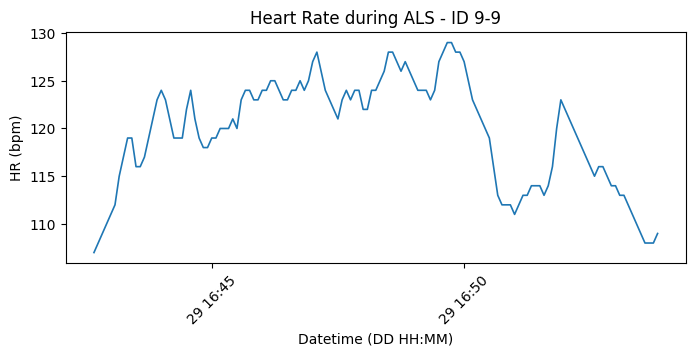

In [7]:
# Show HR data from one participant

patient = data[(data['ID']== '9-9' )]
sav = sav_data[(sav_data['ID']=='9-9')&(sav_data['TASK']==1)]
for _, period in sav.iterrows():
    id = period['ID']
    start = period['DATETIME_START']
    end = period['DATETIME_END']
    filt_data = data[(data['ID']==id)&(data.index>= start) & (data.index<= end)]
plt.figure(figsize=(8,3))
plt.plot(filt_data.index, filt_data['HR'].round().astype('int64'), linewidth=1.2)
plt.xticks(rotation=45)
plt.title('Heart Rate during ALS - ID 9-9')
plt.xlabel('Datetime (DD HH:MM)')
plt.ylabel('HR (bpm)');

# **2. Segmentation**

In [8]:
sav_data.head()

,DATETIME_START,DATETIME_END,TASK,ID
0,2024-09-29 16:28:31+00:00,2024-09-29 16:40:00+00:00,0,8-9
1,2024-09-29 16:28:31+00:00,2024-09-29 16:40:00+00:00,1,4-9
2,2024-09-29 16:28:31+00:00,2024-09-29 16:40:00+00:00,2,0-9
3,2024-09-29 16:28:31+00:00,2024-09-29 16:40:00+00:00,2,16-9
4,2024-09-29 16:28:31+00:00,2024-09-29 16:40:00+00:00,4,9-9


In [14]:
value_counts_output = sav_data['TASK'].value_counts()


# Mapping dictionary
task_names = {
  0: 'Leader',
  1: 'Medication & Defibrillation',
  2: 'Compressions/Airways',
  4: 'Observer'
}

# Rename the index using the mapping
value_counts_output.index = value_counts_output.index.map(task_names)


In [15]:
value_counts_output

,count
TASK,
Compressions/Airways,150
Leader,75
Medication & Defibrillation,75
Observer,57


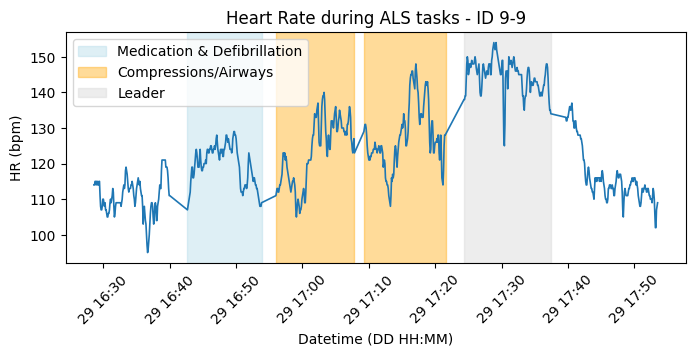

In [10]:
patient = data[(data['ID']== '9-9' )]
sav = sav_data[(sav_data['ID']=='9-9')]
plt.figure(figsize=(8,3))
plt.plot(patient.index, patient['HR'], linewidth=1.2)
plt.xticks(rotation=45)
plt.title('Heart Rate during ALS tasks - ID 9-9')
plt.xlabel('Datetime (DD HH:MM)')
plt.ylabel('HR (bpm)')

for _, row in sav.iterrows():
    task= row['TASK']
    start= row['DATETIME_START']
    end=row['DATETIME_END']
    if task == 0.0:
        plt.axvspan(start,end, color='lightgray' ,alpha=0.4, linestyle='-',label='Leader')
    elif task == 1.0:
        plt.axvspan(start,end, color='lightblue' ,alpha=0.4, linestyle='-',label='Medication & Defibrillation')
    elif task == 2.0:
        plt.axvspan(start,end, color='orange' ,alpha=0.4, linestyle='-',label='Compressions/Airways')


# Remove duplicates in legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.show()


In [17]:
def plot_mean(data,sav_data, task, time=600, p=5):
    time = np.arange(0, time+1,p)
    signal=[]
    color = {0:'gray',1:'lightblue',2:'orange'}
    color=color.get(task,'black')
    task_1 = {0:'Leader',1:'Medication & Defibrillation',2:'Compressions/Airways',4:'Observer'}
    task_1= task_1.get(task,'task')
    task_data = sav_data[(sav_data['TASK']==task)]
    for _,row in task_data.iterrows():
        id = row['ID']
        start = row['DATETIME_START']
        end = row['DATETIME_END']
        hr_data = data[(data['ID']==id)&(data.index>= start) & (data.index<= end)]
        hr_data= hr_data['HR']
        if hr_data.empty:
            continue

        time_r = (hr_data.index -start).total_seconds()
        hr_data.index = time_r
        hr_data = hr_data.groupby(hr_data.index).mean()
        hr5 = hr_data.reindex(time).interpolate(limit_direction='both')
        signal.append(hr5)

    df = pd.DataFrame(signal)
    mean = df.mean()
    std = df.std()
    plt.figure(figsize=(8,4))
    plt.plot(time, mean,color=color)
    plt.fill_between(time,mean-std,mean+std, color=color, alpha=0.3)
    plt.title(f'Average Heart Rate - {task_1}')
    plt.xlabel('Time (s)')
    plt.ylabel('HR (bpm)')
    plt.ylim(80,140)
    plt.show()

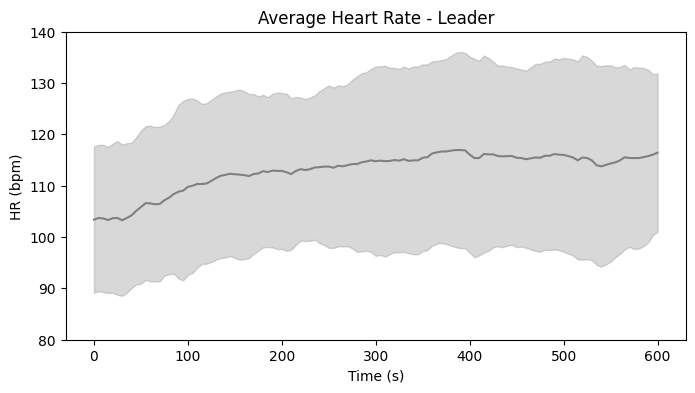

In [20]:
plot_mean(data,sav_data, 0.0, time=600, p=5)

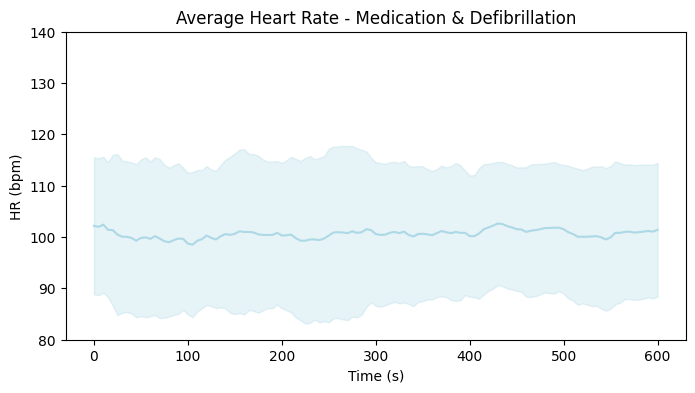

In [21]:
plot_mean(data,sav_data, 1.0, time=600, p=5)

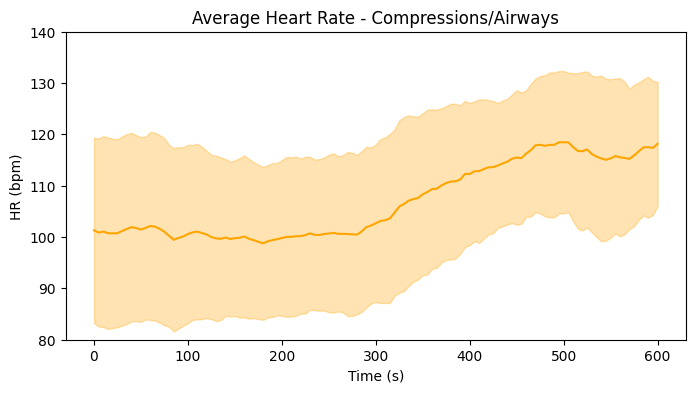

In [22]:
plot_mean(data,sav_data, 2.0, time=600, p=5)

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_mean_edit(data, sav_data, time=600, p=5):
    time = np.arange(0, time+1, p)
    signal_dict = {}
    color_dict = {0: 'gray', 1: 'lightblue', 2: 'orange'}
    task_dict = {0: 'Leader', 1: 'Medication & Defibrillation', 2: 'Compressions/Airways', 4: 'Observer'}

    for task in [0, 1, 2]:
        signal = []
        color = color_dict.get(task, 'black')
        task_name = task_dict.get(task, 'task')
        task_data = sav_data[(sav_data['TASK'] == task)]

        for _, row in task_data.iterrows():
            id = row['ID']
            start = row['DATETIME_START']
            end = row['DATETIME_END']
            hr_data = data[(data['ID'] == id) & (data.index >= start) & (data.index <= end)]
            hr_data = hr_data['HR']

            if hr_data.empty:
                continue

            time_r = (hr_data.index - start).total_seconds()
            hr_data.index = time_r
            hr_data = hr_data.groupby(hr_data.index).mean()
            hr5 = hr_data.reindex(time).interpolate(limit_direction='both')
            signal.append(hr5)

        df = pd.DataFrame(signal)
        mean = df.mean()
        std = df.std()
        signal_dict[task_name] = (mean, std, color)

    plt.figure(figsize=(8, 4))

    for task_name, (mean, std, color) in signal_dict.items():
        plt.plot(time, mean, color=color, label=task_name)
        plt.fill_between(time, mean-std, mean+std, color=color, alpha=0.3)

    plt.title('Average Heart Rate for Different Tasks')
    plt.xlabel('Time (s)')
    plt.ylabel('HR (bpm)')
    plt.ylim(80, 140)
    plt.legend()
    plt.show()

# Example usage
# plot_mean(data, sav_data)



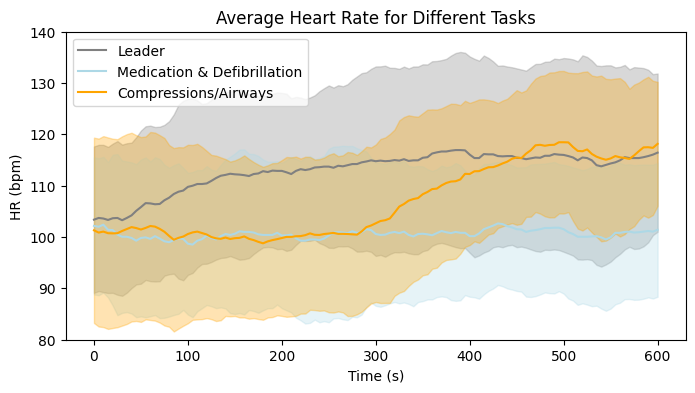

In [21]:
plot_mean_edit(data, sav_data)

# **3. HR and HRV features**

In [23]:
df = pd.read_csv('https://raw.githubusercontent.com/Hospital-Da-Luz-Learning-Health/Workshop-AI-SESAM/refs/heads/main/data/data_hrv.csv', delimiter=',')

HR_mean - Mean Heart Rate (bpm)

NN_intervals - Mean NNI [ms]

SDNN - Standard deviation of NN intervals [ms]

RMSSD - Root mean of squared NNI differences [ms]

vlf_abs - Absolute powers of very low frequency bands [ms^2]

lf_abs - Absolute powers of low frequency bands [ms^2]

SD1 - Standard deviation (SD1) of the major axis of Poincaré plot (linked to parasympathetic nervous system activity)

SD2 - Standard deviation (SD2) of the minor axis of Poincaré plot

SD_ratio - Ratio between SD1 and SD2 (SD2/SD1)

area - Arrea S of the fitted ellipse

In [24]:
df.head()

,ID,TASK,HR_mean,NN_intervals,SDNN,RMSSD,vlf_abs,lf_abs,SD1,SD2,SD_ratio,area
0,8-9,0,83.28,721.68,30.01,9.76,350.79,342.52,6.89,41.75,6.06,904.34
1,4-9,1,118.82,505.44,15.50,8.30,66.33,74.38,5.87,21.07,3.59,388.51
2,16-9,2,103.09,599.83,106.10,14.13,10805.66,1158.10,9.99,149.23,14.94,4682.42
3,9-9,1,119.81,501.92,24.23,6.22,376.94,116.96,4.40,33.28,7.56,460.02
4,16-9,2,106.40,574.13,77.57,14.00,1865.91,1412.64,9.87,108.79,11.03,3371.90


In [25]:
# patient = data[(data['ID']== '2-11' )]
# data_eva = sav_data[(sav_data['ID']=='2-11')& (sav_data['TASK']==0)]
# for _, period in data_eva.iterrows():
#     id = period['ID']
#     start = period['DATETIME_START']
#     end = period['DATETIME_END']

#     filt_data = data[(data['ID']==id)&(data.index>= start) & (data.index<= end)]
#     filt_data.dropna()

#     NN_serie= (60/filt_data['HR']) *1000
#     NN_serie = NN_serie.dropna()
#     print(f'ALS task: {task}')
#     poincare = nl.poincare(NN_serie, show=True)

In [26]:
# Analyse each variable

df.groupby(['TASK'])[['HR_mean','NN_intervals', 'SDNN', 'RMSSD', 'vlf_abs','lf_abs', 'SD1', 'SD2', 'SD_ratio', 'area']].agg(['mean','std','count']).round(2).T

TASK                     0       1        2
HR_mean      mean   114.74  100.65   108.83
             std     17.95   13.75    10.49
             count   42.00   44.00    82.00
NN_intervals mean   538.48  608.26   563.14
             std     90.87   83.71    56.61
             count   42.00   44.00    82.00
SDNN         mean    29.54   25.04    57.34
             std     16.50   11.15    28.00
             count   42.00   44.00    82.00
RMSSD        mean     7.83    8.90    11.62
             std      3.13    3.22     3.74
             count   42.00   44.00    82.00
vlf_abs      mean   419.95  395.61  2900.19
             std    461.42  566.59  3077.11
             count   42.00   44.00    82.00
lf_abs       mean   159.03  182.94   480.24
             std    120.83  142.79   394.72
             count   42.00   44.00    82.00
SD1          mean     5.52    6.29     8.20
             std      2.21    2.28     2.64
             count   42.00   44.00    82.00
SD2          mean    40.92   34.47    80.27
             std     23.15   15.60    39.49
             count   42.00   44.00    82.00
SD_ratio     mean     7.54    5.51     9.70
             std      3.02    1.64     3.53
             count   42.00   44.00    82.00
area         mean   804.88  762.62  2289.40
             std    850.62  591.71  1667.08
             count   42.00   44.00    82.00

In [27]:
# df['TASK'].value_counts()


In [28]:
# var = ['HR_mean','SD1', 'SD2']
# color = {'0':'lightgray','1':'lightblue','2':'orange'}
# for v in var:
#        sns.boxplot(df, x='TASK',y=v,palette=color)
#        plt.show()

In [29]:
# Calculate the Correlation Matrix

from sklearn.metrics import confusion_matrix, classification_report, r2_score, ConfusionMatrixDisplay

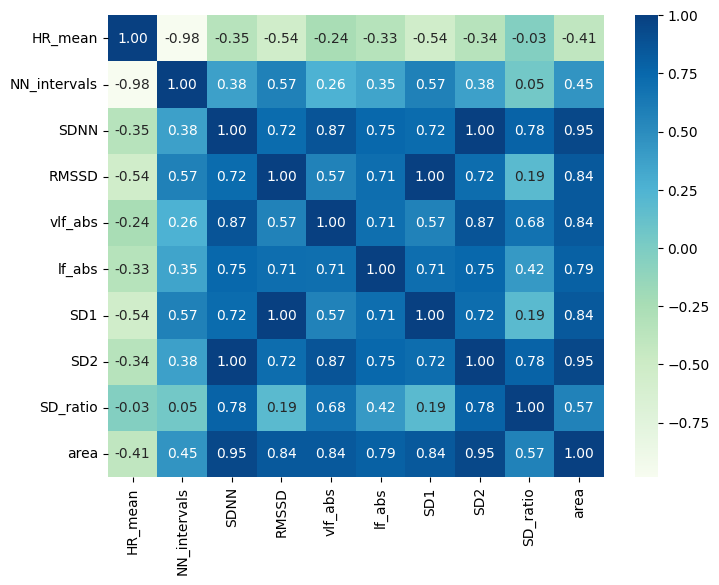

In [30]:
correlation_matrix = df[['HR_mean','NN_intervals', 'SDNN', 'RMSSD', 'vlf_abs','lf_abs', 'SD1', 'SD2', 'SD_ratio', 'area']].corr(method= 'pearson')
plt.figure(figsize=(8,6))
sns.heatmap(correlation_matrix, annot=True, cmap='GnBu', fmt='.2f')
plt.show()

# **3. Train the Model Logistic Regression**

# TRAIN-TEST SPLIT



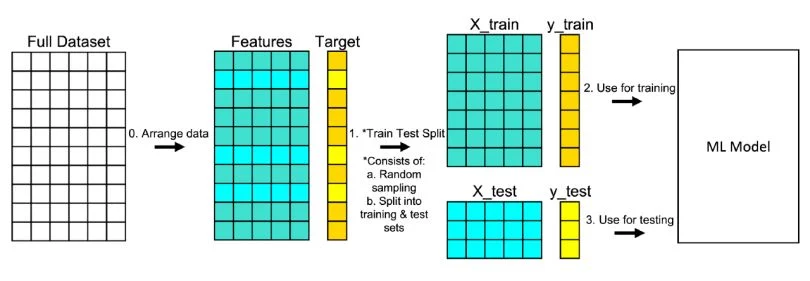

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from imblearn.over_sampling import RandomOverSampler, SMOTE

In [32]:
# Train Test Split

x= df[['HR_mean','NN_intervals', 'SDNN', 'RMSSD', 'vlf_abs','lf_abs', 'SD1', 'SD2', 'SD_ratio', 'area']]
y= df['TASK']

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=10, stratify=y)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [33]:
print(len(x_train))
print(len(y_train))
print(len(x_test))
print(len(y_test))

134
134
34
34


In [34]:
y_train.value_counts()

,count
TASK,
2,65
1,35
0,34


In [35]:
# Train the model

model = LogisticRegression(multi_class='multinomial',solver='lbfgs', class_weight='balanced')
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
y_prob = model.predict_proba(x_test) [:,1]

# **4. Evaluation**

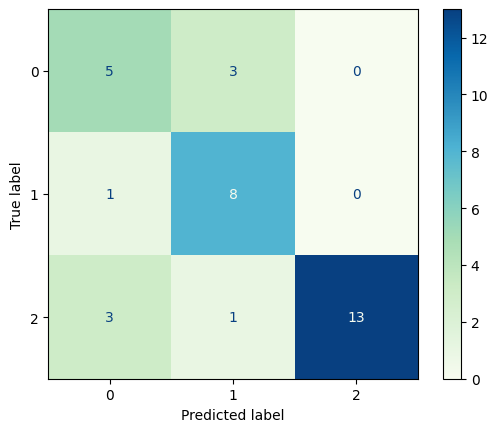

In [36]:
# Calculate Confusion Matrix

conf_matrix= confusion_matrix(y_test,y_pred)
cd=ConfusionMatrixDisplay(confusion_matrix=conf_matrix ,display_labels=model.classes_)
cd.plot(cmap='GnBu')

In [37]:
c=classification_report(y_test,y_pred)
print(c)

              precision    recall  f1-score   support

           0       0.56      0.62      0.59         8
           1       0.67      0.89      0.76         9
           2       1.00      0.76      0.87        17

    accuracy                           0.76        34
   macro avg       0.74      0.76      0.74        34
weighted avg       0.81      0.76      0.77        34



In [41]:
from sklearn.metrics import accuracy_score, recall_score, precision_score

def calculate_metrics(y_test, y_pred):
    # Initialize dictionaries to store metrics for each class
    accuracy = {}
    recall = {}
    precision = {}

    # Get unique classes
    classes = set(y_test)

    # Calculate metrics for each class
    for cls in classes:
        # Create binary arrays for the current class
        y_test_binary = [1 if y == cls else 0 for y in y_test]
        y_pred_binary = [1 if y == cls else 0 for y in y_pred]

        # Calculate accuracy, recall, and precision for the current class
        accuracy[cls] = accuracy_score(y_test_binary, y_pred_binary)
        recall[cls] = recall_score(y_test_binary, y_pred_binary)
        precision[cls] = precision_score(y_test_binary, y_pred_binary)

    return accuracy, recall, precision


accuracy, recall, precision = calculate_metrics(y_test, y_pred)

print("Accuracy per class:", accuracy)
print("Recall per class:", recall)
print("Precision per class:", precision)



Accuracy per class: {0: 0.7941176470588235, 1: 0.8529411764705882, 2: 0.8823529411764706}
Recall per class: {0: 0.625, 1: 0.8888888888888888, 2: 0.7647058823529411}
Precision per class: {0: 0.5555555555555556, 1: 0.6666666666666666, 2: 1.0}


In [42]:
accuracy

{0: 0.7941176470588235, 1: 0.8529411764705882, 2: 0.8823529411764706}

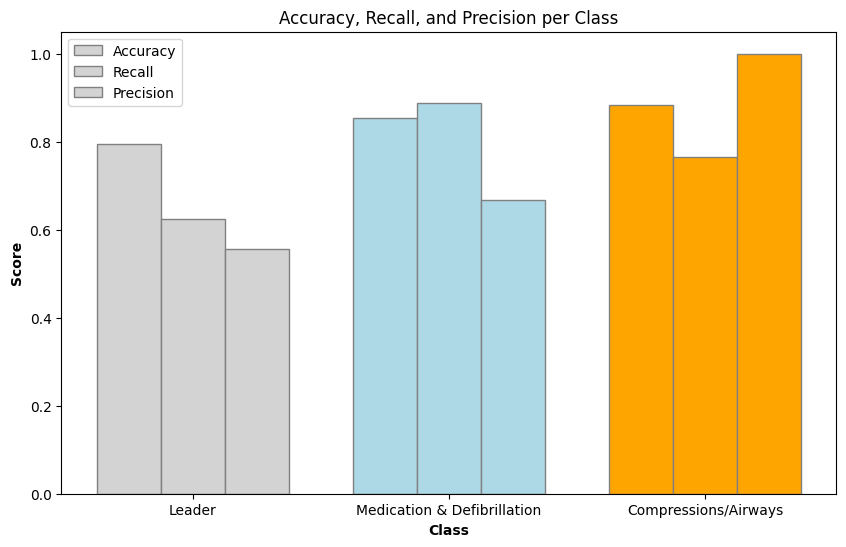

In [44]:
import matplotlib.pyplot as plt
import numpy as np

# Class names mapping
task_names = {0: 'Leader', 1: 'Medication & Defibrillation', 2: 'Compressions/Airways'}

# Colors for each class
colors = {0: 'lightgray', 1: 'lightblue', 2: 'orange'}

# Extract class indices
classes = list(accuracy.keys())

# Extract values for each metric
accuracy_values = [accuracy[cls] for cls in classes]
recall_values = [recall[cls] for cls in classes]
precision_values = [precision[cls] for cls in classes]

# Bar width
bar_width = 0.25

# Positions of the bars on the x-axis
r1 = np.arange(len(classes))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Create the grouped bar chart
plt.figure(figsize=(10, 6))
plt.bar(r1, accuracy_values, color=[colors[cls] for cls in classes], width=bar_width, edgecolor='grey', label='Accuracy')
plt.bar(r2, recall_values, color=[colors[cls] for cls in classes], width=bar_width, edgecolor='grey', label='Recall')
plt.bar(r3, precision_values, color=[colors[cls] for cls in classes], width=bar_width, edgecolor='grey', label='Precision')

# Add labels and title
plt.xlabel('Class', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(classes))], [task_names[cls] for cls in classes])
plt.ylabel('Score', fontweight='bold')
plt.title('Accuracy, Recall, and Precision per Class')

# Add legend
plt.legend()

# Show the plot
plt.show()







### Odds Ratio

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=10)
coef = []
x_np = x.values if hasattr(x,'values') else np.array(x)
y_np = y.values if hasattr(y,'values') else np.array(y)
for train_idx, val_idx in kf.split(x_np):
    x_train_fold, y_train_fold = x_np[train_idx], y_np[train_idx]
    scaler = StandardScaler()
    x_train_fold = scaler.fit_transform(x_train_fold)

    model_kf = LogisticRegression(multi_class='multinomial',solver='lbfgs')
    model_kf.fit(x_train_fold,y_train_fold)

    coef.append(model_kf.coef_)

coef = np.array(coef)

mean = np.mean(coef, axis=0)
std = np.std(coef, axis=0)
lower= mean - 1.96 * std
upper = mean + 1.96 * std
odds = np.exp(mean)
or_lower= np.exp(lower)
or_upper = np.exp(upper)



In [ ]:
features_names = x.columns.to_list()
classes = model_kf.classes_
rows=[]
s=" "
class_label = {0.0: f"{s*18} Leader{s*18}",1.0:f"{s*2} Medication & Defibrillation{s*2} ", 2.0:f"{s*3}   Compressions/Airways  {s*3}"}
for i, cl in enumerate(classes):
    for j, f in enumerate(features_names):
        rows.append({'TASK':class_label[cl],
        'Feature': f,
        'OR': odds[i,j],
        'OR_err_l':or_lower[i,j],
        'OR_err_u':or_upper[i,j]
        })

df_plot = pd.DataFrame(rows)

In [ ]:
def plot_odds(df_or):

    sns.set_theme(style='darkgrid')
    plt.style.use('ggplot')
    g = sns.FacetGrid(df_or, col='TASK',sharex=True,sharey=True,height=6,aspect=0.5)
    g.map_dataframe(sns.scatterplot,x='OR',y='Feature')
    g.set_axis_labels("Odds Ratio")
    for ax in g.axes.flat:
        t= ax.get_title().split("=")[-1]
        task = ax.get_title().split("=")[-1].strip()
        df_or['TASK'] = df_or['TASK'].astype(str).str.strip()
        task_data = df_or[df_or['TASK']==task]
        for _, row in task_data.iterrows():
            ax.errorbar( row['OR'], row['Feature'], xerr=[[row['OR']- row['OR_err_l']], [row['OR_err_u']-row['OR']]],color='Red',capsize=3)
        ax.axvline(1, ls='--', color='gray',lw=0.9)
        ax.set_title(t, fontsize=12, backgroundcolor='lightgray',pad=10)
        ax.set_xticks(np.arange(0.0,6,1))

plt.style.use('default')

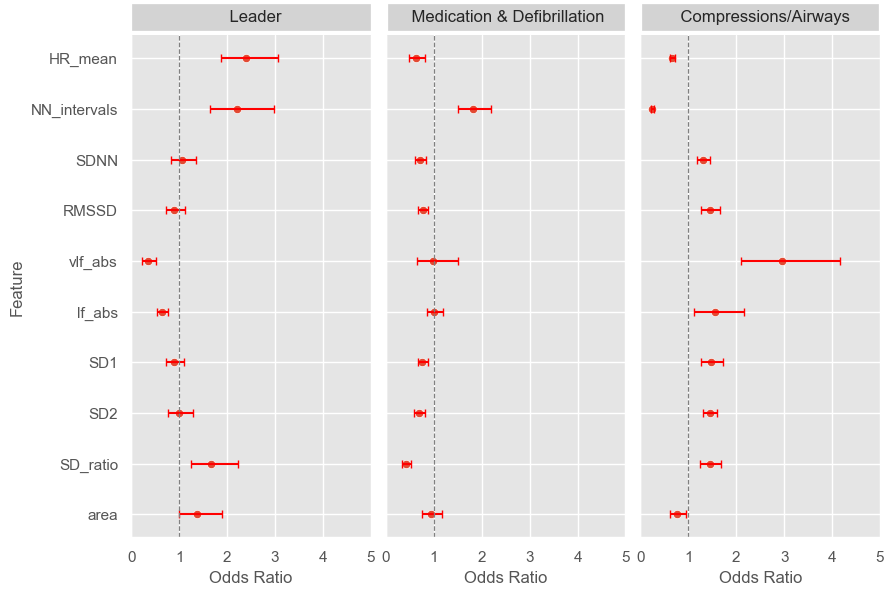

In [ ]:
plot_odds(df_plot)

### Shap Values

In [ ]:
import shap

c:\ProgramData\anaconda3\envs\pyhrv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
classes = model.classes_
n_classes =len(classes)
n_features= len(x.columns)
explainer = shap.Explainer(model, x_train)
shap_values = explainer(x_test)

In [ ]:
shap_values[:,:,0].shape

(34, 10)

In [ ]:
x_test.shape

(34, 10)

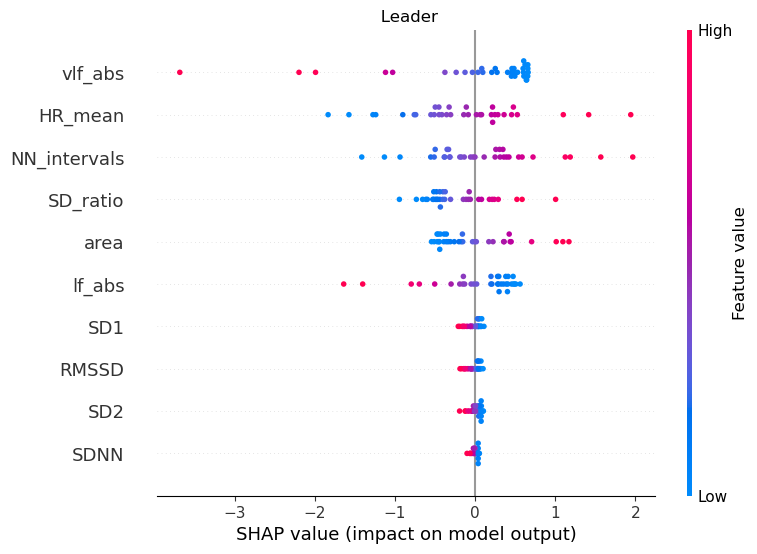

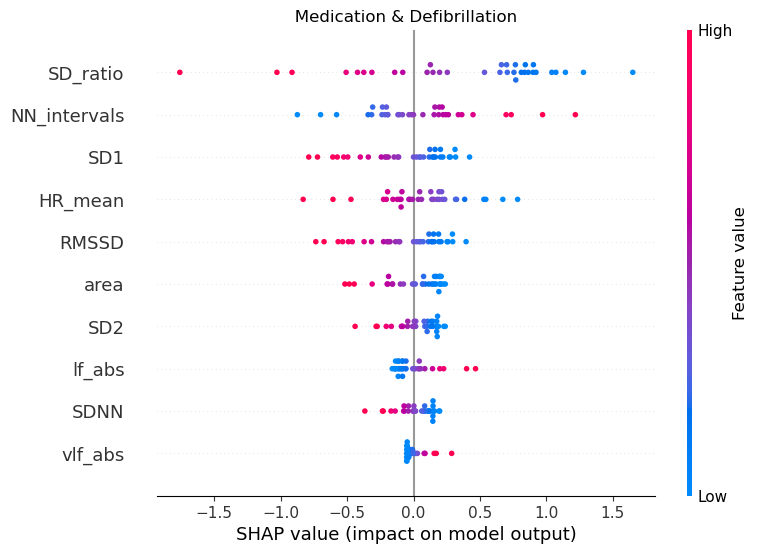

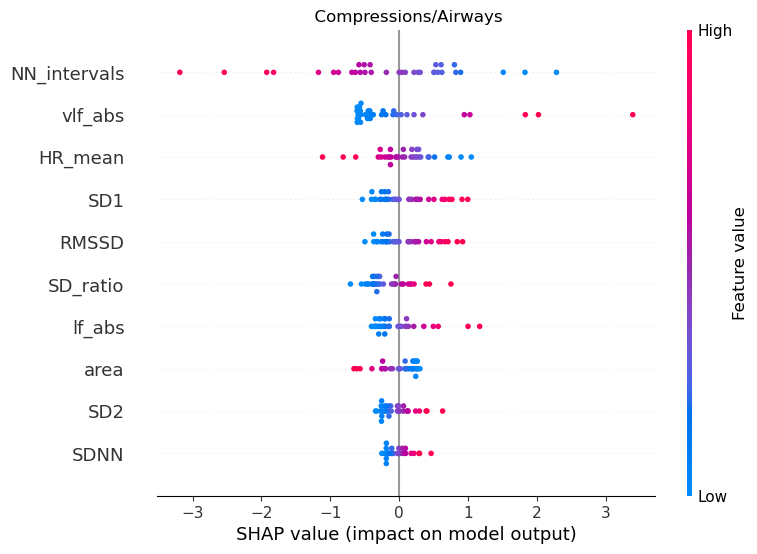

In [ ]:
for i in range(n_classes):
    fig, axes = plt.subplots(2, n_classes)
    shap.summary_plot(shap_values[:,:,i],x_test, feature_names=x.columns, show=False)
    ax= plt.gca()
    ax.set_title(class_label[i])


### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rfc=  RandomForestClassifier(random_state=10,n_estimators=100,class_weight='balanced')
rfc.fit(x_train, y_train)

y_pred = rfc.predict(x_test)
y_prob = rfc.predict_proba(x_test) [:,1]

In [ ]:
conf_matrix= confusion_matrix(y_test,y_pred)
conf_matrix

array([[ 4,  2,  2],
       [ 1,  8,  0],
       [ 0,  2, 15]])

In [ ]:
c=classification_report(y_test,y_pred)
print(c)

              precision    recall  f1-score   support

         0.0       0.80      0.50      0.62         8
         1.0       0.67      0.89      0.76         9
         2.0       0.88      0.88      0.88        17

    accuracy                           0.79        34
   macro avg       0.78      0.76      0.75        34
weighted avg       0.81      0.79      0.79        34



<BarContainer object of 10 artists>

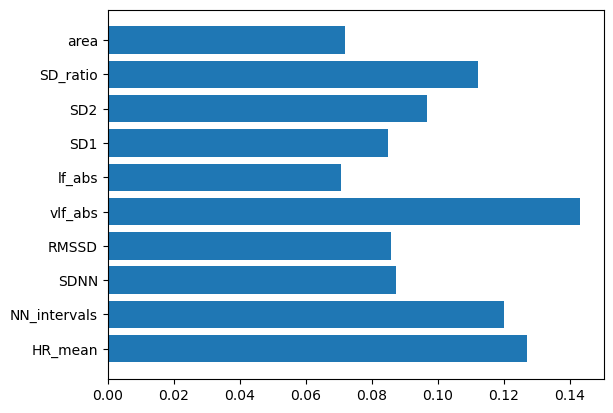

In [ ]:
f = rfc.feature_importances_
plt.barh(x.columns,f)